In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

In [2]:
def extract_frames_from_video(video_path, frame_count=10):
    """
    Extrai um número específico de frames de um vídeo.
    
    :param video_path: Caminho para o vídeo.
    :param frame_count: Número de frames a serem extraídos.
    :return: Lista de frames extraídos.
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(total_frames // frame_count, 1)

    for i in range(0, total_frames, step):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            frames.append(frame)
    
    cap.release()
    return frames

In [3]:
def load_video_dataset(data_dir, frame_count=5):
    """
    Carrega o conjunto de dados de vídeos, extrai frames e atribui rótulos.
    
    :param data_dir: Diretório raiz contendo as subpastas dos vídeos.
    :param frame_count: Número de frames a serem extraídos de cada vídeo.
    :return: Arrays de dados e rótulos.
    """
    X, y = [], []
    class_labels = {'YouTube-real': 0, 'Celeb-synthesis': 1, 'Celeb-real': 0}
    
    for label, value in class_labels.items():
        subdir = os.path.join(data_dir, label)
        for file in os.listdir(subdir):
            if file.endswith('.mp4'):  # Supondo que os vídeos são arquivos .mp4
                video_path = os.path.join(subdir, file)
                frames = extract_frames_from_video(video_path, frame_count=frame_count)
                for frame in frames:
                    X.append(frame)
                    y.append(value)
    
    return X, y


In [4]:
def apply_sobel_filter(image, target_size=(256, 256)):
    """
    Aplica o filtro Sobel a uma imagem para detecção de bordas.

    :param image: Imagem a ser processada.
    :param target_size: Tamanho alvo para a imagem processada (largura, altura).
    :return: Imagem com filtro Sobel aplicado.
    """
    try:
        # Converter imagem para escala de cinza
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Aplicar filtros Sobel nas direções x e y
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
        
        # Calcular magnitude da borda
        sobel = cv2.magnitude(sobelx, sobely)

        # Redimensionar a imagem para o tamanho alvo
        sobel_resized = cv2.resize(sobel, target_size)

        return sobel_resized
    
    except Exception as e:
        print(f"Erro ao aplicar o filtro Sobel: {e}")
        return None

In [5]:
def process_in_batches(X, batch_size=100, target_size=(256, 256)):
    """
    Processa dados em lotes para reduzir o consumo de memória.

    :param X: Conjunto de dados de imagens.
    :param batch_size: Tamanho do lote.
    :param target_size: Tamanho alvo para as imagens processadas (largura, altura).
    :return: Dados processados.
    """
    X_processed = []
    
    # Dividir dados em lotes e processar cada lote
    for i in range(0, len(X), batch_size):
        batch = X[i:i + batch_size]
        
        # Aplicar filtro Sobel a cada imagem do lote
        batch_sobel = [apply_sobel_filter(frame, target_size) for frame in batch]
        
        # Filtrar imagens processadas corretamente
        batch_sobel = [sobel for sobel in batch_sobel if sobel is not None]
        
        X_processed.extend(batch_sobel)
        
    return np.array(X_processed)


In [6]:
def build_cnn(input_shape):
    """
    Constroi o modelo de CNN.
    
    :param input_shape: Forma da entrada do modelo.
    :return: Modelo CNN compilado.
    """
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [7]:
# Carregar o conjunto de dados de vídeos
data_dir = 'Celeb-DF'
X, y = load_video_dataset(data_dir)

In [8]:
# Processar em lotes
X_sobel = process_in_batches(X, batch_size=100, target_size=(256, 256))

# Normalizar os dados
X_sobel = X_sobel / 255.0

# Expandir as dimensões para incluir o canal de cor
X_sobel = np.expand_dims(X_sobel, axis=-1)

In [9]:
# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_sobel, y, test_size=0.2, random_state=42)

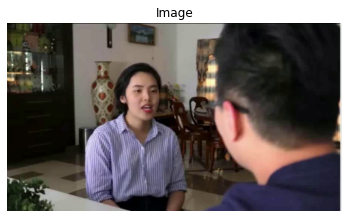

In [10]:
image = X[0]

if image.shape[-1] == 1:
    image = image.squeeze(-1)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Image')
plt.axis('off')  # Hide the axes
plt.show()

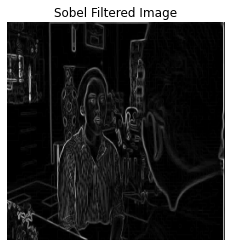

In [11]:
image = X_sobel[0]

if image.shape[-1] == 1:
    image = image.squeeze(-1)

plt.imshow(image, cmap='gray')
plt.title('Sobel Filtered Image')
plt.axis('off')  # Hide the axes
plt.show()

Teste de modelos

In [12]:
def evaluate_model(model_path, X_test, y_test, class_names=['Class 0', 'Class 1']):
    """
    Avalia um modelo carregado em termos de acurácia, ROC-AUC e relatório de classificação.
    
    :param model_path: Caminho para o arquivo do modelo.
    :param X_test: Dados de teste.
    :param y_test: Rótulos de teste.
    :param class_names: Nomes das classes para o relatório de classificação.
    :return: Tuple contendo a acurácia, o ROC-AUC e o relatório de classificação.
    """
    # Carregar o modelo
    model = load_model(model_path)
    
    # Fazer previsões
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    # Calcular a acurácia
    accuracy = accuracy_score(y_test, y_pred)
    
    # Calcular o ROC-AUC
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    
    # Gerar o relatório de classificação
    report = classification_report(y_test, y_pred, target_names=class_names)
    
    return accuracy, roc_auc, report

In [14]:
# Usar a função para comparar os modelos
model_paths = ['Model/meu_modelo_Nosobel.h5', 'Model/meu_modelo_sobel.h5', 'Model\meu_modelo_Sobel_Efficientnet_Model.h5']
for path in model_paths:
    accuracy, roc_auc, report = evaluate_model(path, X_test, y_test)
    print(f"Modelo: {path}")
    print(f"Acurácia: {accuracy:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("Relatório de Classificação:")
    print(report)

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step
Modelo: Model/meu_modelo_Nosobel.h5
Acurácia: 0.4434
ROC-AUC: 0.7193
Relatório de Classificação:
              precision    recall  f1-score   support

     Class 0       0.37      0.89      0.52       475
     Class 1       0.79      0.21      0.33       912

    accuracy                           0.44      1387
   macro avg       0.58      0.55      0.43      1387
weighted avg       0.65      0.44      0.40      1387



44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step
Modelo: Model/meu_modelo_sobel.h5
Acurácia: 0.9142
ROC-AUC: 0.9342
Relatório de Classificação:
              precision    recall  f1-score   support

     Class 0       0.96      0.78      0.86       475
     Class 1       0.90      0.98      0.94       912

    accuracy                           0.91      1387
   macro avg       0.93      0.88      0.90      1387
weighted avg       0.92      0.91      0.91      1387



44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 512ms/step
Modelo: Model\meu_modelo_Sobel_Efficientnet_Model.h5
Acurácia: 0.9041
ROC-AUC: 0.9763
Relatório de Classificação:
              precision    recall  f1-score   support

     Class 0       0.81      0.94      0.87       475
     Class 1       0.97      0.88      0.92       912

    accuracy                           0.90      1387
   macro avg       0.89      0.91      0.90      1387
weighted avg       0.91      0.90      0.91      1387

